In [2]:
!git clone https://github.com/LingxiaoShawn/USD3.git

Cloning into 'USD3'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 62 (delta 35), reused 35 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 24.65 KiB | 6.16 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [3]:
cd USD3

/kaggle/working/USD3


In [4]:
!wget https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/main/sprites_1788_16x16.npy

--2025-02-06 15:22:08--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/main/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 3.171.171.6, 3.171.171.104, 3.171.171.65, ...
Connecting to huggingface.co (huggingface.co)|3.171.171.6|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1738858928&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODg1ODkyOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZjVlNzVmYmNmMDhiYTM3OTI0MWY1ODk2NmM2MmE

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from discrete_diffusion import UnifiedDiscreteDiffusion
import matplotlib.pyplot as plt
import os

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
num_epochs = 10
lr = 3e-4
num_classes = 125  # 5^3 color discretization
image_size = 16
num_steps = 500  # Discrete diffusion steps
save_dir = 'samples'
os.makedirs(save_dir, exist_ok=True)

# Load and preprocess data
class SpriteDataset(Dataset):
    def __init__(self, path):
        data = np.load(path)  # (1788, 16, 16, 3)
        data = data.astype(np.float32) / 255.0
        
        # Discretize into 5 bins per channel
        bins = np.linspace(0, 1, 5, endpoint=False)[1:]
        discretized = np.zeros(data.shape[:-1], dtype=np.int64)
        for i in range(3):
            discretized += (np.digitize(data[..., i], bins, right=False) * (5 ** (2 - i)))
        
        self.data = torch.from_numpy(discretized).long()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = SpriteDataset('sprites_1788_16x16.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Model Architecture: UNet with Time Embedding

Here, we define a time embedding module, a residual block, and a UNet architecture. The network embeds discrete inputs, processes them with down-sampling, a middle block, and up-sampling, and finally outputs logits for each class.

In [6]:
# UNet Model

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000) / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, t):
        pos_enc = t[:, None] * self.inv_freq[None, :]
        return torch.cat([torch.sin(pos_enc), torch.cos(pos_enc)], dim=-1)

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.SiLU()
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t):
        h = self.conv(x) + self.mlp(t)[..., None, None]
        return h + self.res_conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.embed = nn.Embedding(num_classes, 64)
        time_dim = 128
        
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Down-sampling blocks
        self.down1 = Block(64, 128, time_dim)
        self.down2 = Block(128, 256, time_dim)
        self.down3 = Block(256, 512, time_dim)
        
        # Middle block
        self.mid = Block(512, 512, time_dim)
        
        # Up-sampling blocks
        self.up3 = Block(1024, 256, time_dim)
        self.up2 = Block(512, 128, time_dim)
        self.up1 = Block(256, 64, time_dim)
        
        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x, t):
        # x: (B, H, W), t: (B,)
        x = self.embed(x).permute(0, 3, 1, 2)  # (B, C, H, W)
        t_emb = self.time_mlp(t)
        
        # Down-sampling path
        x1 = self.down1(x, t_emb)
        x2 = self.down2(F.max_pool2d(x1, 2), t_emb)
        x3 = self.down3(F.max_pool2d(x2, 2), t_emb)
        
        # Middle block
        x = self.mid(F.max_pool2d(x3, 2), t_emb)
        
        # Up-sampling path
        x = F.interpolate(x, scale_factor=2)
        x = self.up3(torch.cat([x, x3], 1), t_emb)
        x = F.interpolate(x, scale_factor=2)
        x = self.up2(torch.cat([x, x2], 1), t_emb)
        x = F.interpolate(x, scale_factor=2)
        x = self.up1(torch.cat([x, x1], 1), t_emb)
        
        return self.final(x).permute(0, 2, 3, 1)  # (B, H, W, C)

# Diffusion Model Initialization

We initialize our UNet model and the diffusion process using the UnifiedDiscreteDiffusion class. This class manages the forward (noising) and backward (denoising) processes.

In [7]:
# Initialize model and diffusion
model = UNet(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

diffusion = UnifiedDiscreteDiffusion(
    num_steps=num_steps,
    num_classes=num_classes,
    noise_schedule_type='cosine',
    noise_schedule_args={}
)

# Sampling Function for Visualization

This function generates a grid of samples from the diffusion model. A uniform noise distribution m is provided to the sampling method. The sampled discrete values are then mapped back to RGB using predefined bin centers.

In [8]:
def save_sample(epoch):
    model.eval()
    with torch.no_grad():
        # Create a uniform noise distribution m.
        # Shape: (batch, image_size, image_size, num_classes)
        batch = 16  # generating 16 samples
        m = torch.full((batch, image_size, image_size, num_classes), 1/num_classes, device=device)
        
        sample = diffusion.sample(
            model,
            num_backward_steps=num_steps,
            m=m,  # Pass the uniform noise distribution
        )
        
        # Convert to RGB
        sample = sample.cpu().numpy()
        r = sample // 25
        g = (sample % 25) // 5
        b = sample % 5
        
        # Convert back to [0,1] range using bin centers
        bins = np.linspace(0.1, 0.9, 5)
        r_img = bins[r].clip(0, 1)
        g_img = bins[g].clip(0, 1)
        b_img = bins[b].clip(0, 1)
        images = np.stack([r_img, g_img, b_img], axis=-1)
        
        # Save grid of images
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i])
            ax.axis('off')
        plt.savefig(f'{save_dir}/sample_epoch{epoch:03d}.png')
        plt.close()
    # Optionally set model back to train mode: model.train()

Epoch 1 | Average Loss: 19.5631


Epoch 2 | Average Loss: 13.6672


Epoch 3 | Average Loss: 11.3191


Epoch 4 | Average Loss: 9.7544


Epoch 5 | Average Loss: 8.6903


Epoch 6 | Average Loss: 7.8448


Epoch 7 | Average Loss: 7.2277


Epoch 8 | Average Loss: 6.8463


Epoch 9 | Average Loss: 6.3688


Epoch 10 | Average Loss: 6.1699


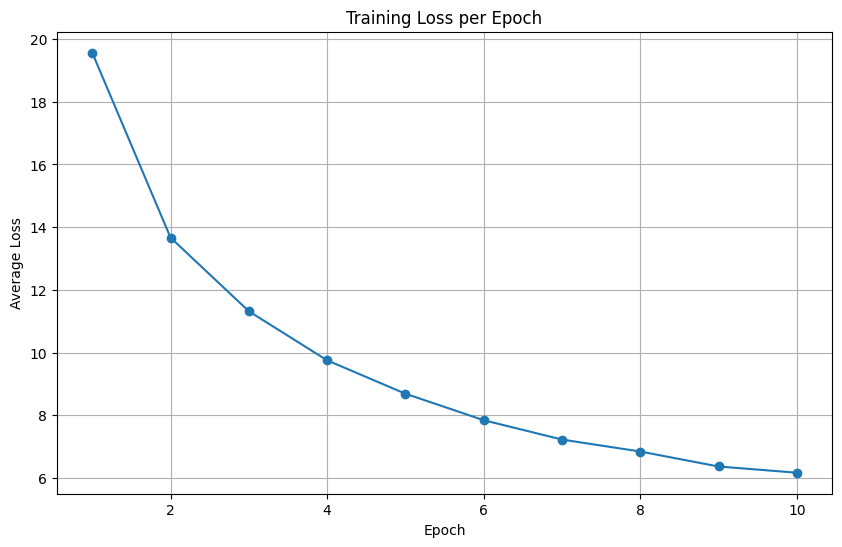

In [9]:
from tqdm import tqdm  # For progress visualization

# Initialize a list to store average loss per epoch
loss_history = []

# Training loop with progress bar
for epoch in range(num_epochs):
    total_loss = 0
    # Wrap the dataloader with tqdm for a progress bar
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in pbar:
        x_0 = batch.to(device)
        
        # Sample random timesteps (ensuring t >= 1)
        t = torch.randint(1, num_steps, (x_0.shape[0],), device=device)
        
        # Diffusion process: generate x_t from x_0
        x_t = diffusion.qt_0_sample(x_0, t, m=None)
        
        # Predict with the UNet model
        logits = model(x_t, t.float() / num_steps)
        
        # Compute loss
        loss_dict = diffusion.compute_loss(
            logits,
            x_t,
            x_0,
            t,
            m=None,
            coeff_ce=0.1,
            coeff_vlb=1.0
        )
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()
        
        total_loss += loss_dict['loss'].item()
        # Update the progress bar with the current loss value
        pbar.set_postfix(loss=loss_dict['loss'].item())
    
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)  # Record average loss for this epoch
    print(f'Epoch {epoch+1} | Average Loss: {avg_loss:.4f}')
    
    # Generate and save samples after each epoch
    save_sample(epoch+1)
    torch.save(model.state_dict(), f'model_epoch{epoch+1}.pth')

# Plot the loss curve after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.savefig('training_loss_curve.png')
plt.show()

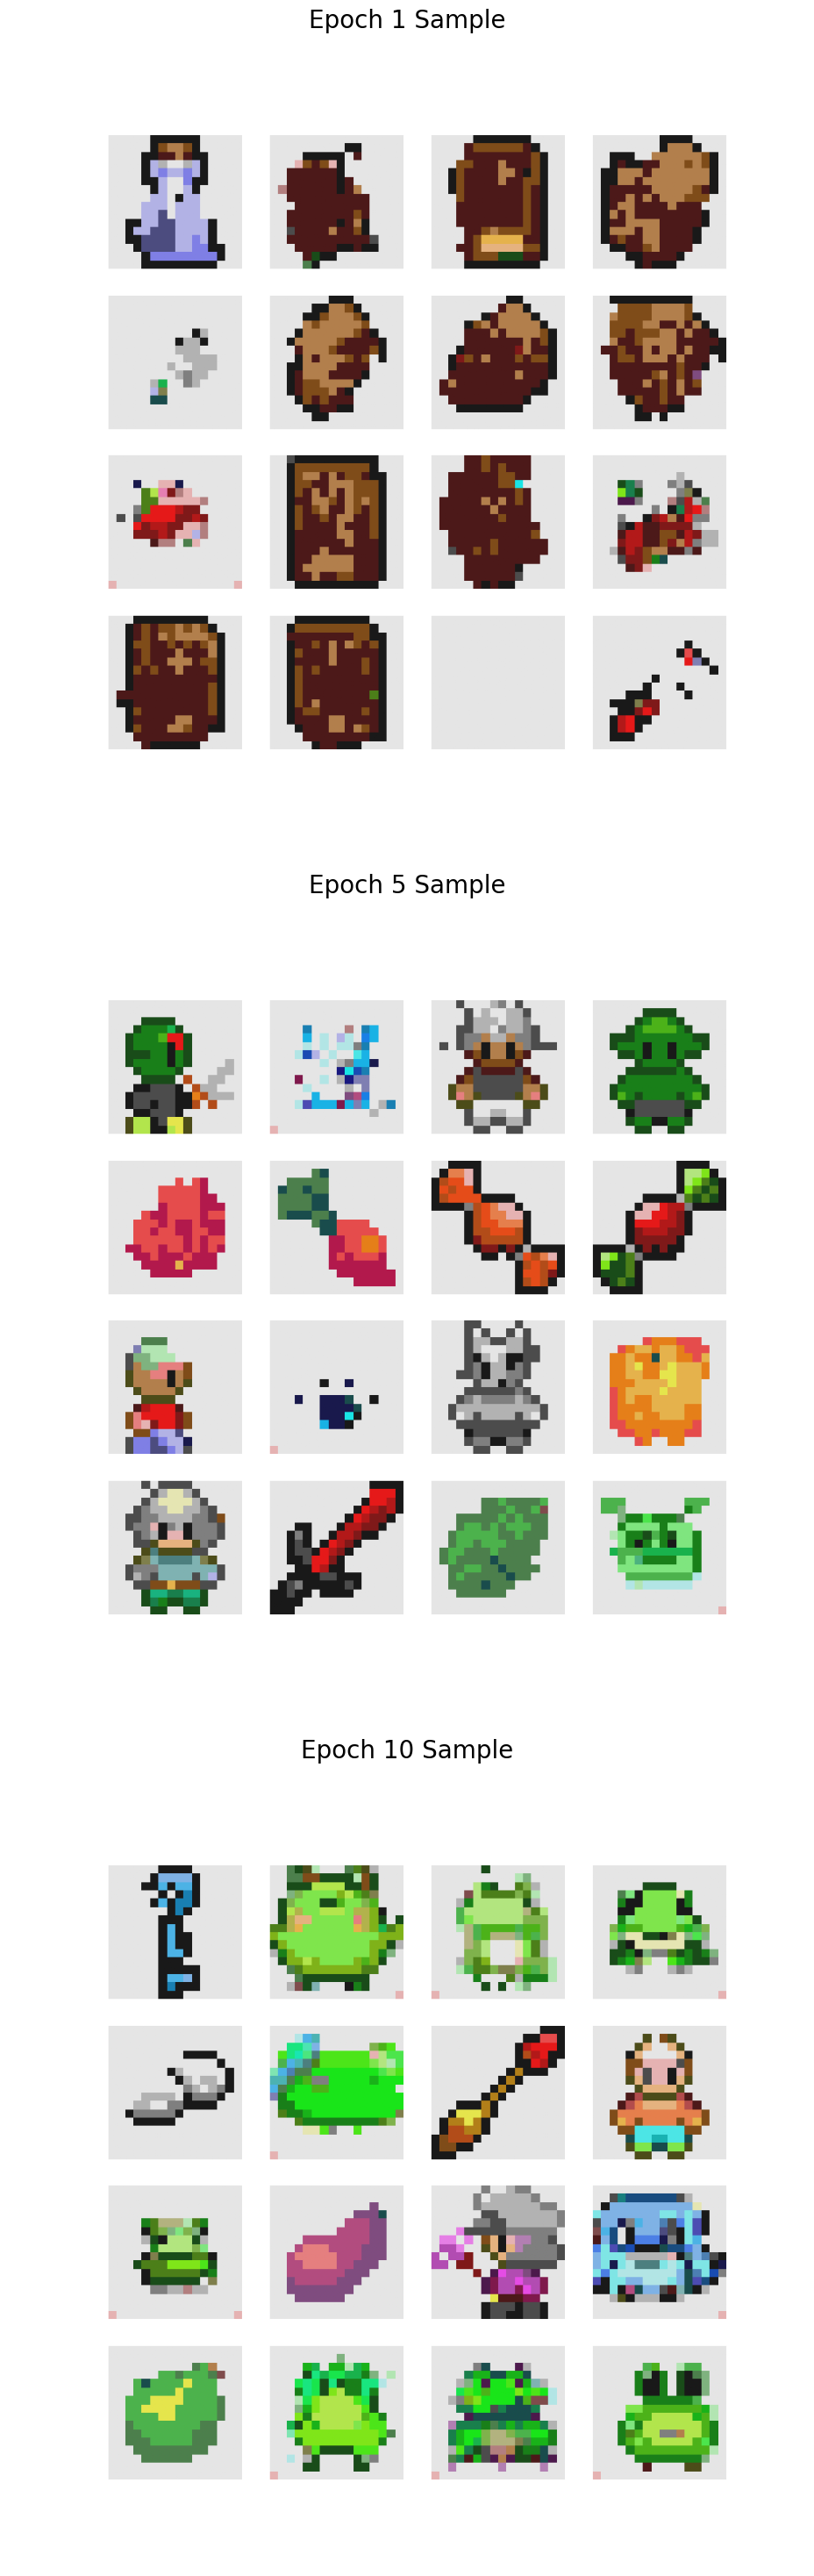

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define image paths and titles
image_paths = [
    '/kaggle/working/USD3/samples/sample_epoch001.png',
    '/kaggle/working/USD3/samples/sample_epoch005.png',
    '/kaggle/working/USD3/samples/sample_epoch010.png'
]
titles = ['Epoch 1 Sample', 'Epoch 5 Sample', 'Epoch 10 Sample']

# Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))

# Display each image with its title
for ax, img_path, title in zip(axes, image_paths, titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title, fontsize=20, pad=10)
    ax.axis('off')  # Hide the axes

# Show the plot
plt.tight_layout(pad=3.0)
plt.show()


# Improved method

## we changed the transition rate matrix definition in the paper by adding another matrix S, amplifying transition probability of close pixel values

In [31]:
!rm -rf USD3
!git clone https://github.com/curioserve/USD3.git
!cd USD3

In [42]:
import sys

if 'discrete_diffusion' in sys.modules:
    del sys.modules['discrete_diffusion']


In [49]:
from discrete_diffusion import *

# Initialize model and diffusion
model = UNet(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

diffusion = OrdinalUnifiedDiscreteDiffusion(
    num_steps=num_steps,
    num_classes=num_classes,
    noise_schedule_type='cosine',
    noise_schedule_args={}
)

Epoch 1 | Average Loss: 15.3098


Epoch 2 | Average Loss: 8.7103


Epoch 3 | Average Loss: 5.9137


Epoch 4 | Average Loss: 4.2863


Epoch 5 | Average Loss: 3.2737


Epoch 6 | Average Loss: 2.7092


Epoch 7 | Average Loss: 2.2788


Epoch 8 | Average Loss: 2.0695


Epoch 9 | Average Loss: 1.9413


Epoch 10 | Average Loss: 1.8147


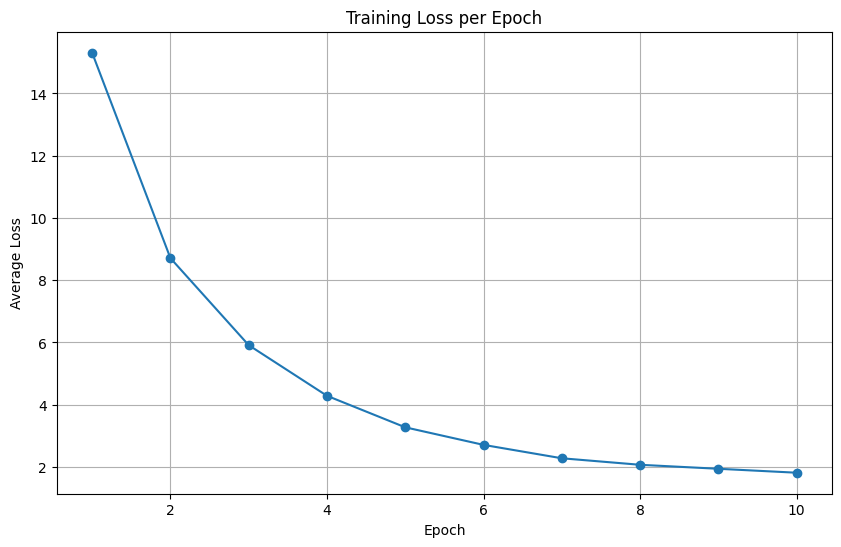

In [50]:
from tqdm import tqdm  # For progress visualization

# Initialize a list to store average loss per epoch
ordinal_loss_history = []

# Training loop with progress bar
for epoch in range(num_epochs):
    total_loss = 0
    # Wrap the dataloader with tqdm for a progress bar
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in pbar:
        x_0 = batch.to(device)
        
        # Sample random timesteps (ensuring t >= 1)
        t = torch.randint(1, num_steps, (x_0.shape[0],), device=device)
        
        # Diffusion process: generate x_t from x_0
        x_t = diffusion.qt_0_sample(x_0, t, m=None)
        
        # Predict with the UNet model
        logits = model(x_t, t.float() / num_steps)
        
        # Compute loss
        loss_dict = diffusion.compute_loss(
            logits,
            x_t,
            x_0,
            t,
            m=None,
            coeff_ce=0.1,
            coeff_vlb=1.0
        )
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()
        
        total_loss += loss_dict['loss'].item()
        # Update the progress bar with the current loss value
        pbar.set_postfix(loss=loss_dict['loss'].item())
    
    avg_loss = total_loss / len(dataloader)
    ordinal_loss_history.append(avg_loss)  # Record average loss for this epoch
    print(f'Epoch {epoch+1} | Average Loss: {avg_loss:.4f}')
    
    # Generate and save samples after each epoch
    save_sample(epoch+1)
    torch.save(model.state_dict(), f'model_epoch{epoch+1}.pth')

# Plot the loss curve after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), ordinal_loss_history, marker='o', linestyle='-')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.savefig('training_loss_curve.png')
plt.show()

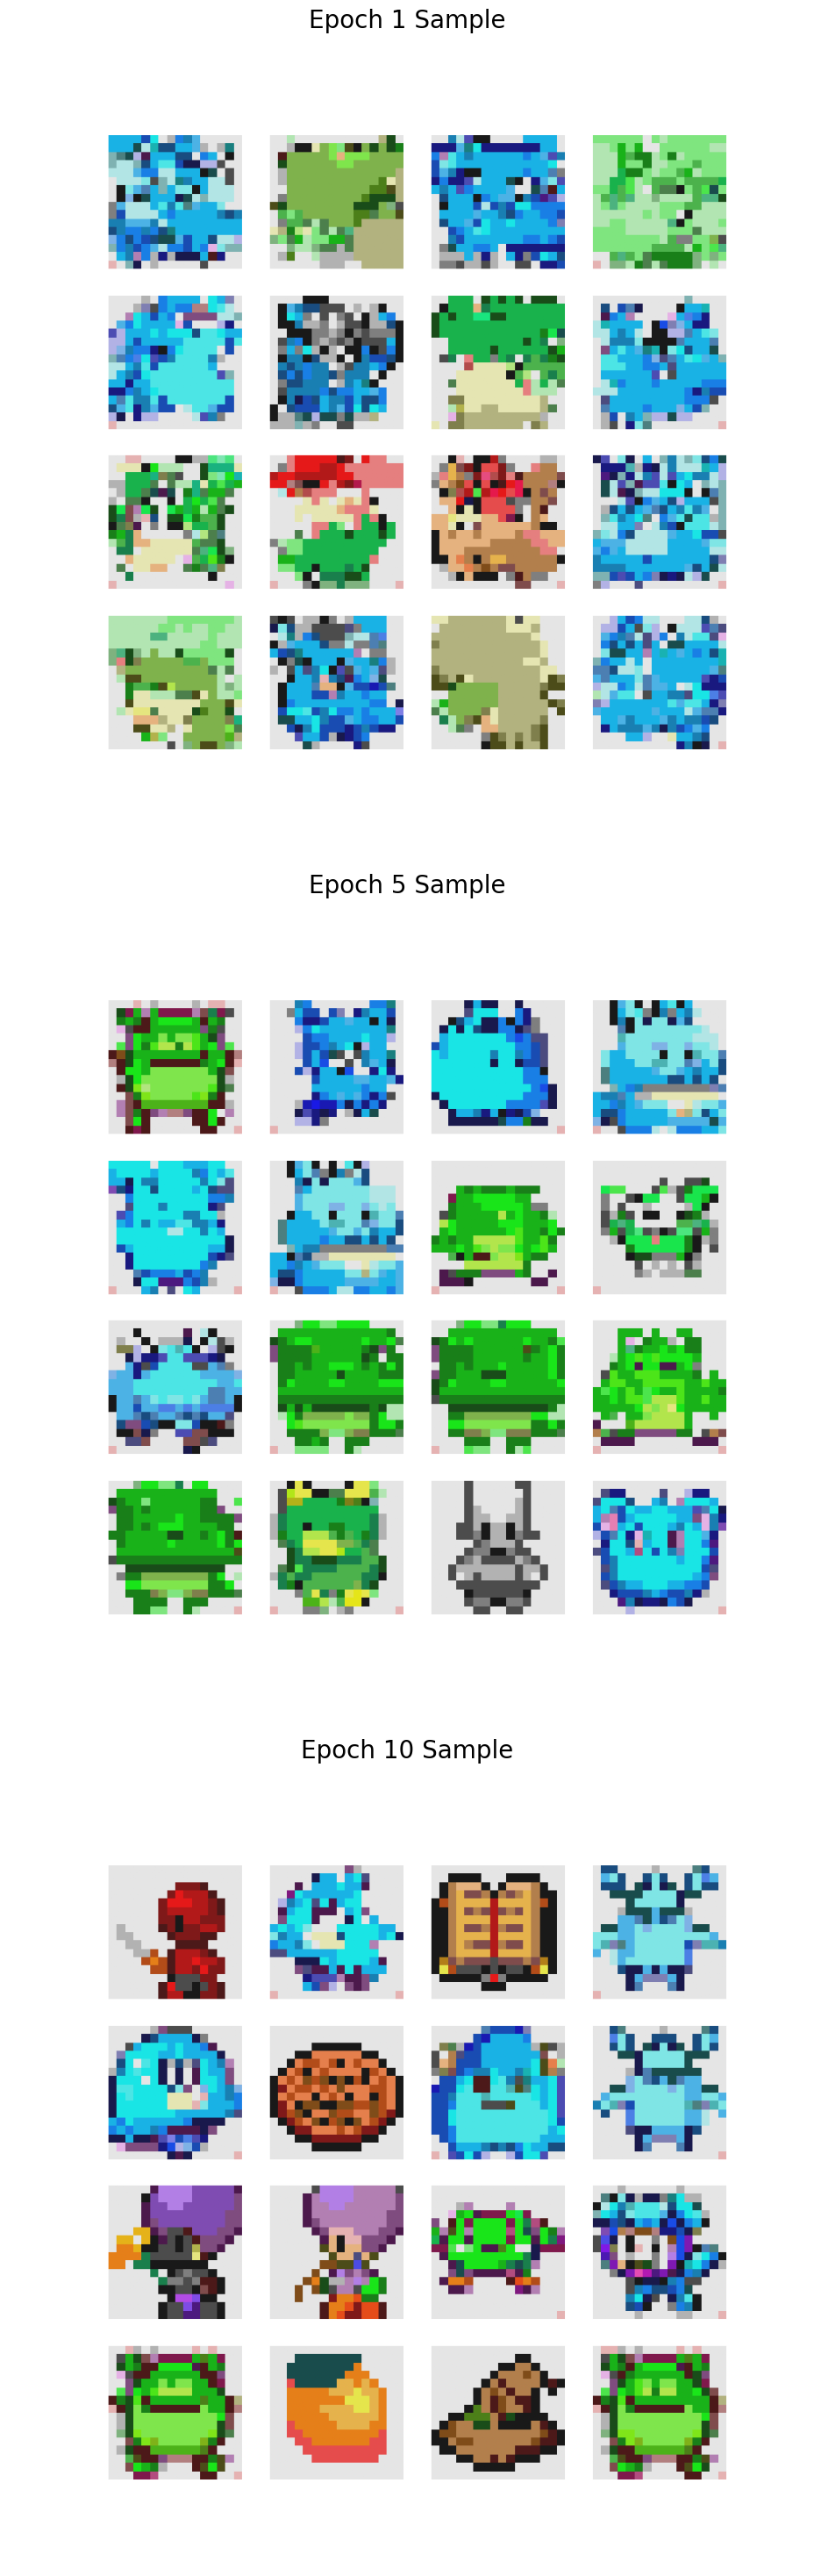

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define image paths and titles
image_paths = [
    '/kaggle/working/USD3/samples/sample_epoch001.png',
    '/kaggle/working/USD3/samples/sample_epoch005.png',
    '/kaggle/working/USD3/samples/sample_epoch010.png'
]
titles = ['Epoch 1 Sample', 'Epoch 5 Sample', 'Epoch 10 Sample']

# Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))

# Display each image with its title
for ax, img_path, title in zip(axes, image_paths, titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(title, fontsize=20, pad=10)
    ax.axis('off')  # Hide the axes

# Show the plot
plt.tight_layout(pad=3.0)
plt.show()


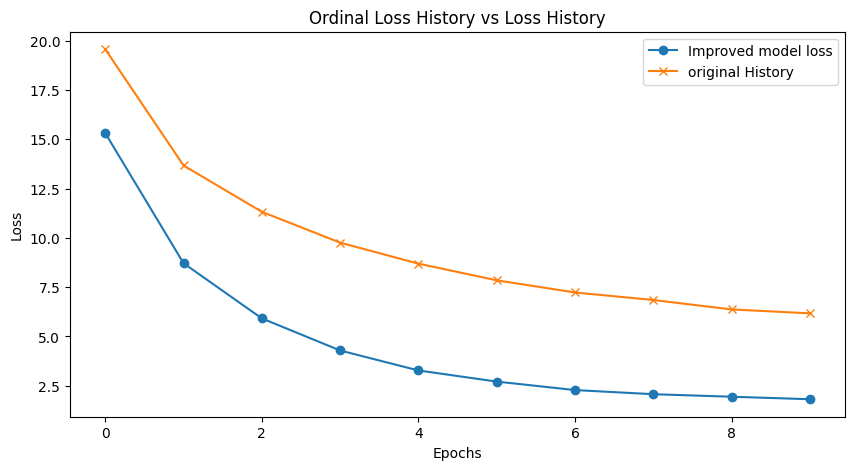

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(ordinal_loss_history, label='Improved model loss', marker='o')
plt.plot(loss_history, label='original History', marker='x')

# Adding title and labels
plt.title('Ordinal Loss History vs Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()